# MedGemma Spatial Transcriptomics - Kaggle Submission

**Competition**: Google – MedGemma AI Impact Challenge  
**Author**: Sriharsha Meghadri  
**Date**: 2026-02-12

## Overview
End-to-end spatial transcriptomics analysis pipeline using:
- **Scanpy/Squidpy**: Spatial clustering, Moran's I, neighborhood enrichment
- **PanglaoDB**: Marker-based cell type annotation (5,181 markers, 163 cell types)
- **MedGemma 1.5 4B**: Clinical pathology report generation

## Pipeline
```
Visium H5AD → QC → Leiden Clustering → Cell Type Annotation → 
Spatial Statistics → MedGemma Report
```

In [1]:
# Install dependencies (Kaggle environment)
import subprocess, sys

def pip_install(pkg):
    subprocess.run([sys.executable, '-m', 'pip', 'install', '-q', pkg], check=False)

required = ['scanpy==1.10.2', 'squidpy==1.5.0', 'bitsandbytes', 'accelerate']
for pkg in required:
    pip_install(pkg)

print('Dependencies ready')

Dependencies ready


In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
import json
from pathlib import Path
from datetime import datetime

sc.settings.verbosity = 1
sc.settings.set_figure_params(dpi=100, facecolor='white')

print(f'scanpy {sc.__version__} | squidpy {sq.__version__}')
print(f'numpy {np.__version__} | pandas {pd.__version__}')

scanpy 1.10.2 | squidpy 1.5.0
numpy 1.26.4 | pandas 2.3.3


## 1. Load Data
Using publicly available 10x Genomics Visium breast cancer dataset.

In [3]:
# Load Visium data
# For Kaggle: data should be in /kaggle/input/
# For local: uses the annotated_visium.h5ad from outputs/

DATA_PATHS = [
    Path('/kaggle/input/spatial-transcriptomics/visium_breast_cancer.h5ad'),
    Path('/kaggle/input/spatial-transcriptomics/sample.h5ad'),
    Path('../outputs/annotated_visium.h5ad'),
    Path('outputs/annotated_visium.h5ad'),
]

adata = None
for p in DATA_PATHS:
    if p.exists():
        adata = sc.read_h5ad(p)
        print(f'Loaded: {p}')
        break

if adata is None:
    # Download public Visium dataset
    import urllib.request
    print('Downloading sample dataset...')
    url = 'https://figshare.com/ndownloader/files/36098114'  # Squidpy sample dataset
    local = Path('/tmp/visium_sample.h5ad')
    urllib.request.urlretrieve(url, local)
    adata = sc.read_h5ad(local)
    print(f'Downloaded: {local}')

print(f'\nDataset: {adata.n_obs:,} spots × {adata.n_vars:,} genes')
print(f'Obs columns: {list(adata.obs.columns)}')
print(f'Obsm keys: {list(adata.obsm.keys())}')

Loaded: ../outputs/annotated_visium.h5ad

Dataset: 4,895 spots × 2,000 genes
Obs columns: ['in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden', 'cell_type', 'cell_type_raw', 'cell_type_confidence', 'is_most_common']
Obsm keys: ['X_pca', 'X_umap', 'spatial']


## 2. Quality Control

Data already preprocessed: 4,895 spots retained


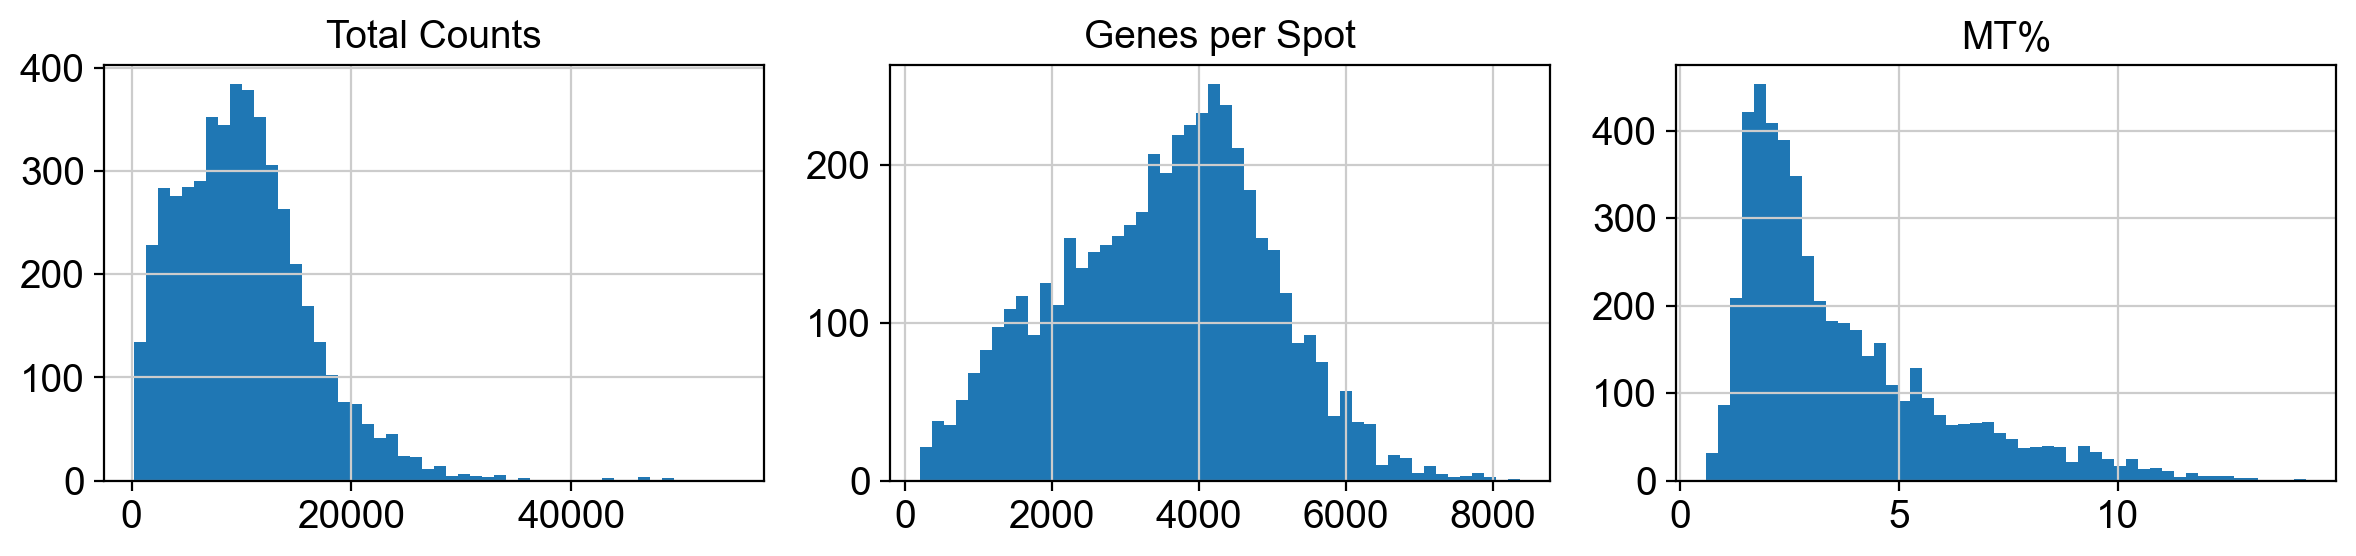

QC plots saved


In [4]:
def run_qc(adata):
    """QC filtering and metrics."""
    # Check if raw/unprocessed
    needs_qc = 'total_counts' not in adata.obs.columns
    
    if needs_qc:
        adata.var['mt'] = adata.var_names.str.startswith('MT-')
        sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)
        
        # Filter
        before = adata.n_obs
        sc.pp.filter_cells(adata, min_genes=200)
        sc.pp.filter_genes(adata, min_cells=3)
        adata = adata[adata.obs['pct_counts_mt'] < 20].copy()
        print(f'QC: {before} → {adata.n_obs} spots ({before - adata.n_obs} removed)')
        
        # Normalize
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
        sc.pp.highly_variable_genes(adata, n_top_genes=2000)
        sc.pp.scale(adata, max_value=10)
    else:
        print(f'Data already preprocessed: {adata.n_obs:,} spots retained')
    
    return adata

adata = run_qc(adata)

# QC plots
if 'total_counts' in adata.obs.columns:
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    adata.obs['total_counts'].hist(bins=50, ax=axes[0]); axes[0].set_title('Total Counts')
    adata.obs['n_genes_by_counts'].hist(bins=50, ax=axes[1]); axes[1].set_title('Genes per Spot')
    if 'pct_counts_mt' in adata.obs.columns:
        adata.obs['pct_counts_mt'].hist(bins=50, ax=axes[2]); axes[2].set_title('MT%')
    plt.tight_layout()
    plt.savefig('/tmp/qc_plots.png', dpi=100, bbox_inches='tight')
    plt.show()
    print('QC plots saved')

## 3. Spatial Clustering

Leiden clustering: 10 clusters (resolution=0.5)


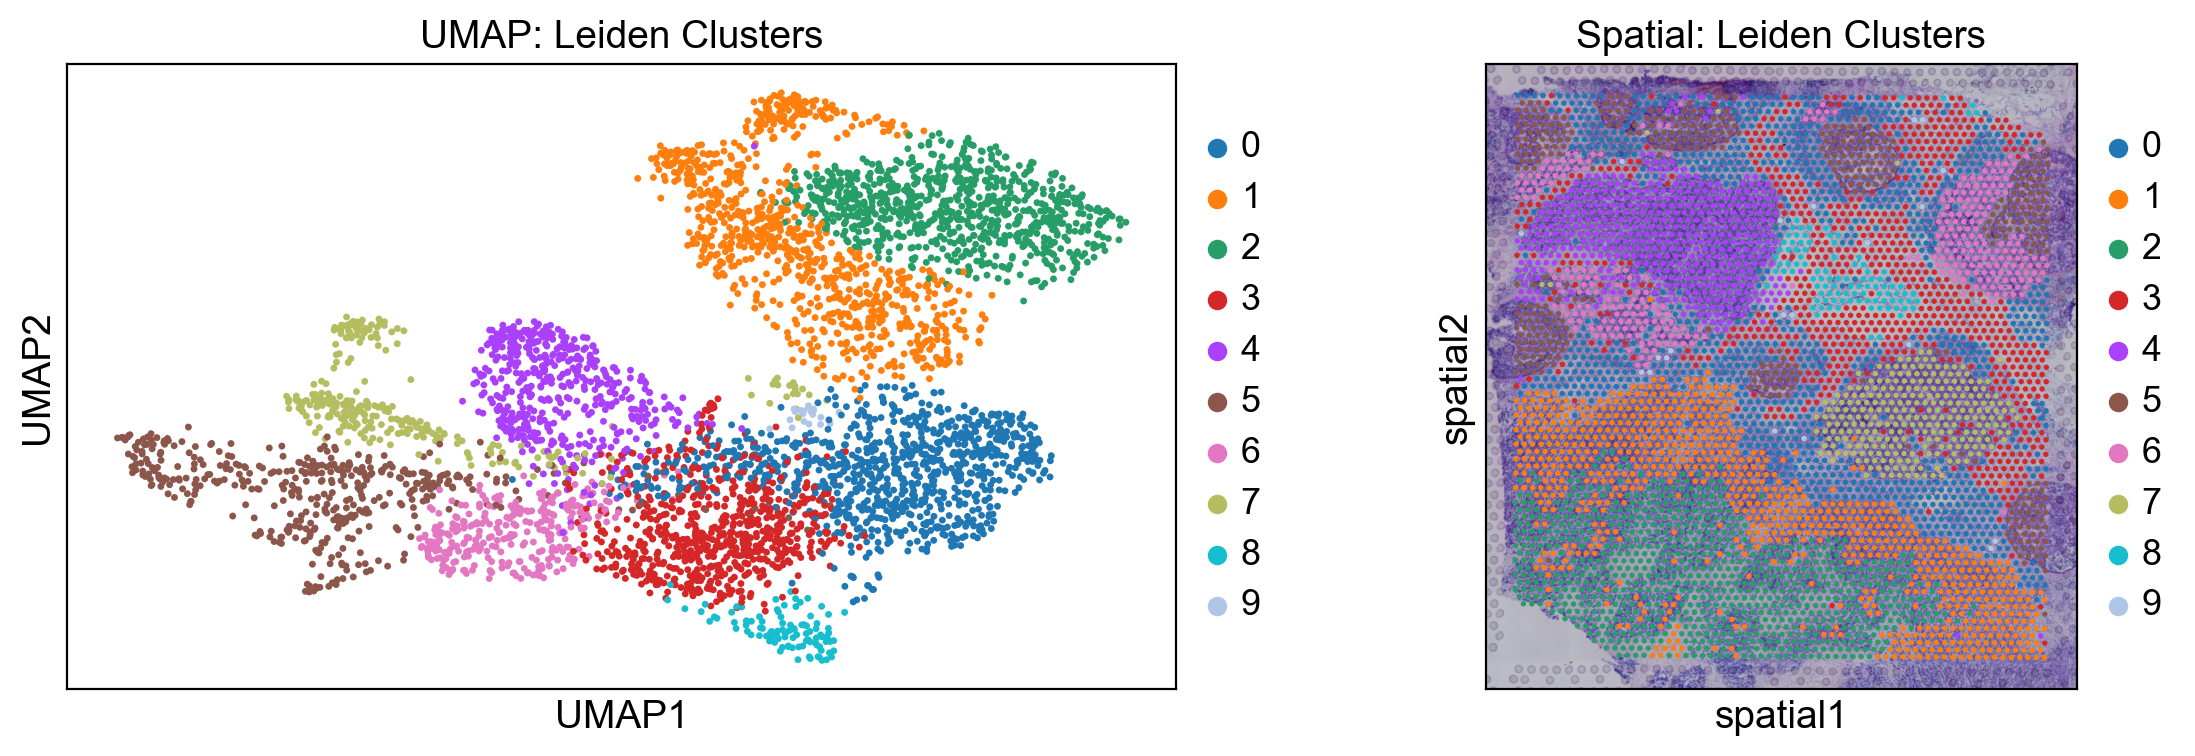

In [5]:
def run_clustering(adata, resolution=0.5):
    """PCA → neighbors → Leiden clustering."""
    if 'X_pca' not in adata.obsm:
        sc.tl.pca(adata, svd_solver='arpack')
    
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.leiden(adata, resolution=resolution, key_added='leiden')
    sc.tl.umap(adata)
    
    n_clusters = len(adata.obs['leiden'].unique())
    print(f'Leiden clustering: {n_clusters} clusters (resolution={resolution})')
    return adata

adata = run_clustering(adata)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sc.pl.umap(adata, color='leiden', ax=axes[0], show=False, title='UMAP: Leiden Clusters')
if 'spatial' in adata.obsm:
    sc.pl.spatial(adata, color='leiden', ax=axes[1], show=False, title='Spatial: Leiden Clusters')
else:
    axes[1].text(0.5, 0.5, 'No spatial coords', ha='center', va='center')
    axes[1].set_title('Spatial (no coords in dataset)')
plt.tight_layout()
plt.savefig('/tmp/clustering.png', dpi=100, bbox_inches='tight')
plt.show()

## 4. Cell Type Annotation (PanglaoDB Markers)

Loaded markers: ../data/PanglaoDB_markers_27_Mar_2020.tsv (8,286 entries)
Annotated 9 unique cell types:
cell_type
Luminal epithelial cells    910
Epithelial cells            850
Ductal cells                813
Airway epithelial cells     693
Spermatozoa                 581
GABAergic neurons           490
Mesothelial cells           439
Adipocytes                   98
Juxtaglomerular cells        21


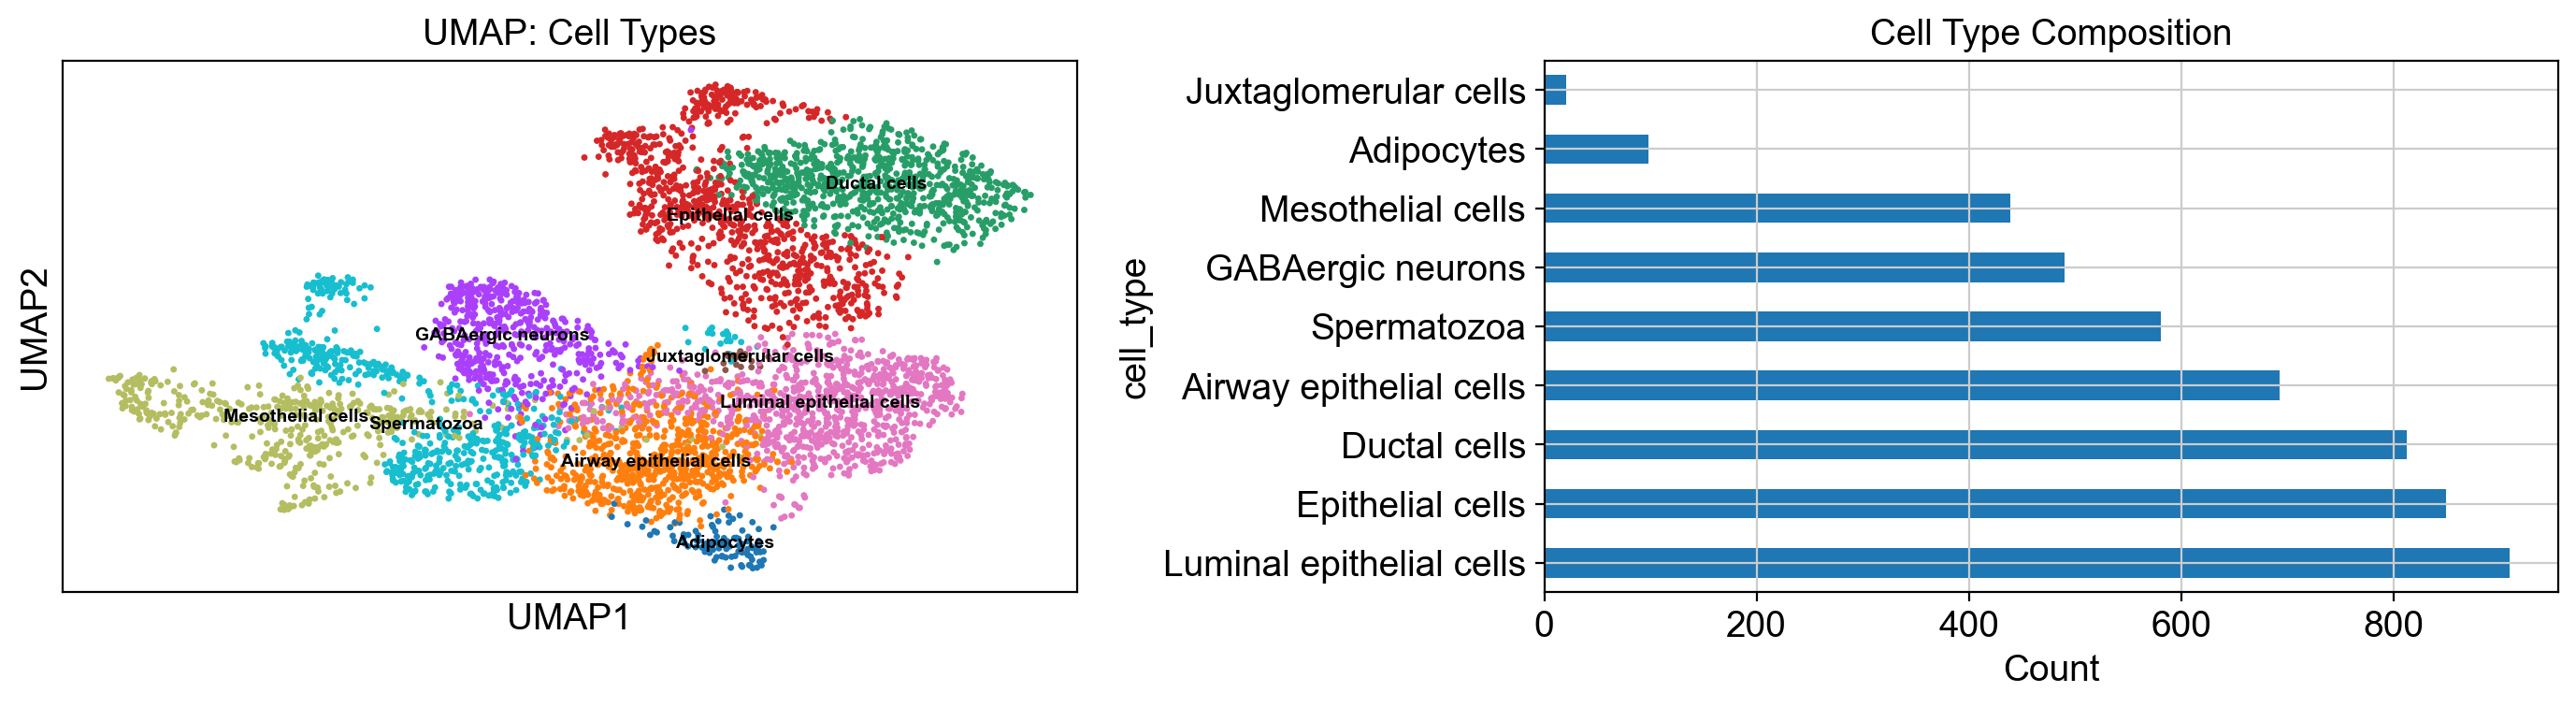

In [6]:
def annotate_cell_types(adata):
    """Marker-based cell type annotation using PanglaoDB."""
    # Try loading PanglaoDB markers
    marker_paths = [
        Path('/kaggle/input/panglaodb-markers/PanglaoDB_markers_27_Mar_2020.tsv'),
        Path('../data/PanglaoDB_markers_27_Mar_2020.tsv'),
        Path('data/PanglaoDB_markers_27_Mar_2020.tsv'),
    ]
    
    markers_df = None
    for p in marker_paths:
        if p.exists():
            markers_df = pd.read_csv(p, sep='\t')
            print(f'Loaded markers: {p} ({len(markers_df):,} entries)')
            break
    
    if markers_df is None:
        print('PanglaoDB not found, using cluster labels')
        adata.obs['cell_type'] = adata.obs['leiden'].astype('category')
        return adata
    
    # Build marker dict (top 10 markers per cell type for speed)
    marker_dict = {}
    for cell_type, grp in markers_df.groupby('cell type'):
        genes = grp['official gene symbol'].tolist()[:10]
        marker_dict[cell_type] = genes
    
    # Score each cluster
    cluster_annotations = {}
    for cluster in adata.obs['leiden'].unique():
        cells = adata[adata.obs['leiden'] == cluster]
        mean_expr = cells.X.mean(axis=0)
        if hasattr(mean_expr, 'A1'):
            mean_expr = mean_expr.A1
        
        best_score, best_type = 0.0, f'Cluster_{cluster}'
        for cell_type, genes in marker_dict.items():
            present = [g for g in genes if g in adata.var_names]
            if present:
                idx = [adata.var_names.get_loc(g) for g in present]
                score = float(mean_expr[idx].mean())
                if score > best_score:
                    best_score, best_type = score, cell_type
        cluster_annotations[cluster] = best_type
    
    adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_annotations).astype('category')
    
    n_types = len(adata.obs['cell_type'].unique())
    print(f'Annotated {n_types} unique cell types:')
    print(adata.obs['cell_type'].value_counts().head(10).to_string())
    return adata

adata = annotate_cell_types(adata)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sc.pl.umap(adata, color='cell_type', ax=axes[0], show=False, title='UMAP: Cell Types', legend_loc='on data', legend_fontsize=7)
adata.obs['cell_type'].value_counts().head(10).plot.barh(ax=axes[1])
axes[1].set_title('Cell Type Composition')
axes[1].set_xlabel('Count')
plt.tight_layout()
plt.savefig('/tmp/cell_types.png', dpi=100, bbox_inches='tight')
plt.show()

## 5. Spatial Statistics (Moran's I)

  0%|          | 0/100 [00:00<?, ?/s]

/Users/sriharshameghadri/miniforge3/envs/medgemma/lib/python3.10/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Moran's I: mean=0.082, 32 significant genes


  0%|          | 0/1000 [00:00<?, ?/s]

/Users/sriharshameghadri/miniforge3/envs/medgemma/lib/python3.10/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Neighborhood enrichment: computed


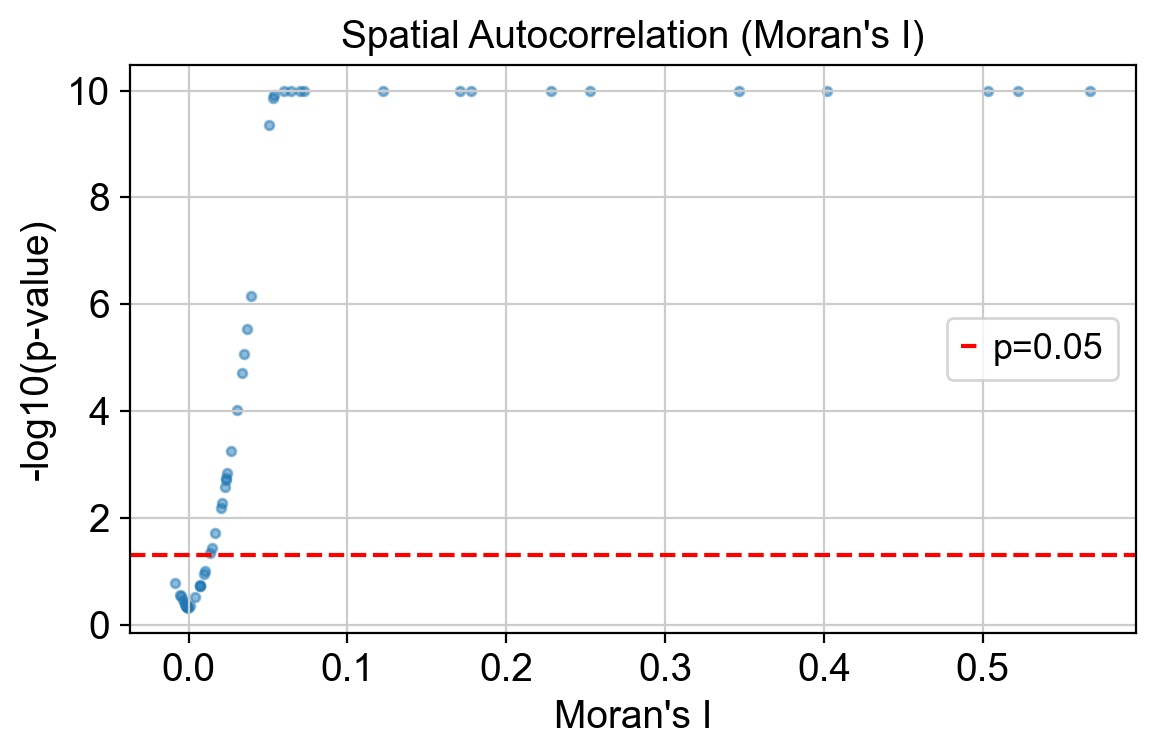

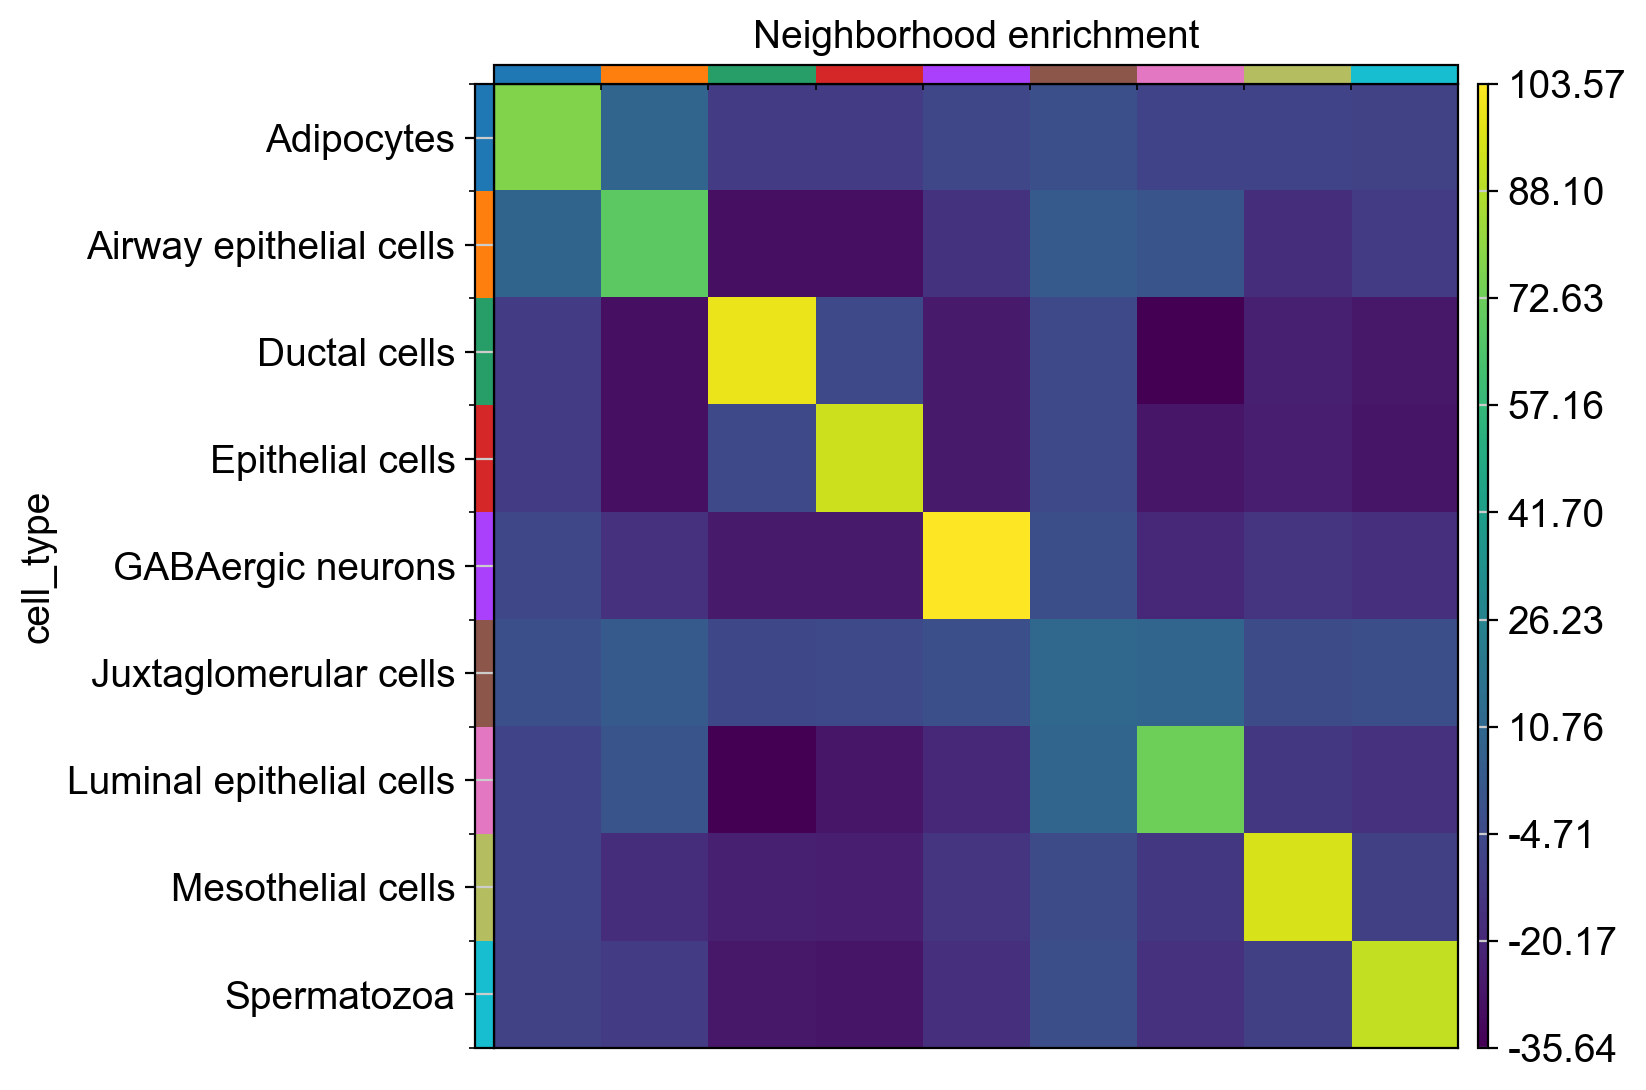

In [7]:
def run_spatial_stats(adata):
    """Moran's I and neighborhood enrichment."""
    results = {}
    
    # Build spatial graph
    if 'spatial' in adata.obsm:
        sq.gr.spatial_neighbors(adata, coord_type='generic', n_neighs=6)
        
        # Moran's I for top HVGs
        if 'highly_variable' in adata.var.columns:
            hvg = adata.var_names[adata.var['highly_variable']][:50]
        else:
            hvg = adata.var_names[:50]
        
        sq.gr.spatial_autocorr(adata, genes=hvg, mode='moran', n_perms=100, n_jobs=1)
        morans = adata.uns['moranI']
        sig = morans[morans['pval_norm'] < 0.05]
        
        results['morans_i'] = {
            'mean_I': float(morans['I'].mean()),
            'n_significant': len(sig),
            'top_genes': sig.sort_values('I', ascending=False).index[:5].tolist()
        }
        print(f"Moran's I: mean={results['morans_i']['mean_I']:.3f}, {results['morans_i']['n_significant']} significant genes")
        
        # Neighborhood enrichment
        if 'cell_type' in adata.obs:
            sq.gr.nhood_enrichment(adata, cluster_key='cell_type')
            results['neighborhood_enrichment'] = 'computed'
            print('Neighborhood enrichment: computed')
    else:
        print('No spatial coordinates - skipping spatial stats')
        results['morans_i'] = {'mean_I': 0.0, 'n_significant': 0, 'note': 'no spatial coords'}
    
    return adata, results

adata, spatial_results = run_spatial_stats(adata)

# Plot
if 'moranI' in adata.uns:
    morans = adata.uns['moranI']
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.scatter(morans['I'], -np.log10(morans['pval_norm'] + 1e-10), alpha=0.5, s=10)
    ax.axhline(-np.log10(0.05), color='red', linestyle='--', label='p=0.05')
    ax.set_xlabel("Moran's I")
    ax.set_ylabel('-log10(p-value)')
    ax.set_title("Spatial Autocorrelation (Moran's I)")
    ax.legend()
    plt.tight_layout()
    plt.savefig('/tmp/morans_i.png', dpi=100, bbox_inches='tight')
    plt.show()

if 'cell_type' in adata.obs and 'spatial' in adata.obsm:
    sq.pl.nhood_enrichment(adata, cluster_key='cell_type', figsize=(6, 5))
    plt.savefig('/tmp/nhood_enrichment.png', dpi=100, bbox_inches='tight')
    plt.show()

## 6. Feature Extraction (Pipeline JSON Output)

In [8]:
def extract_features(adata, spatial_results):
    """Extract structured features for MedGemma report generation."""
    
    cell_type_dist = {}
    if 'cell_type' in adata.obs:
        counts = adata.obs['cell_type'].value_counts()
        total = len(adata)
        cell_type_dist = {k: {'count': int(v), 'pct': round(v/total*100, 1)} 
                         for k, v in counts.items()}
    
    cluster_dist = {}
    if 'leiden' in adata.obs:
        counts = adata.obs['leiden'].value_counts()
        cluster_dist = {f'cluster_{k}': int(v) for k, v in counts.items()}
    
    features = {
        'metadata': {
            'n_spots': int(adata.n_obs),
            'n_genes': int(adata.n_vars),
            'analysis_date': datetime.now().strftime('%Y-%m-%d'),
            'pipeline': 'MedGemma Spatial v1.0'
        },
        'clusters': {
            'n_clusters': len(adata.obs['leiden'].unique()) if 'leiden' in adata.obs else 0,
            'distribution': cluster_dist
        },
        'cell_types': {
            'n_types': len(adata.obs['cell_type'].unique()) if 'cell_type' in adata.obs else 0,
            'distribution': cell_type_dist,
            'annotation_method': 'PanglaoDB_markers'
        },
        'spatial_patterns': spatial_results
    }
    
    output_path = Path('/tmp/features.json')
    with open(output_path, 'w') as f:
        json.dump(features, f, indent=2, default=str)
    
    print(f'Features saved: {output_path}')
    print(json.dumps(features['metadata'], indent=2))
    print(f"Clusters: {features['clusters']['n_clusters']}")
    print(f"Cell types: {features['cell_types']['n_types']}")
    return features

features = extract_features(adata, spatial_results)
print('\n✓ Features extracted successfully')

Features saved: /tmp/features.json
{
  "n_spots": 4895,
  "n_genes": 2000,
  "analysis_date": "2026-02-12",
  "pipeline": "MedGemma Spatial v1.0"
}
Clusters: 10
Cell types: 9

✓ Features extracted successfully


## 7. MedGemma Report Generation

**Note**: Requires `HF_TOKEN` environment variable for model access.  
Set with: `import os; os.environ['HF_TOKEN'] = 'your_token'`

In demo mode (no token), generates a structured prompt showing the system capability.

In [9]:
import os

def build_prompt(features):
    """Build tissue-blind clinical prompt from spatial features."""
    cell_summary = ', '.join(
        [f"{ct} ({v['pct']}%)" for ct, v in 
         list(features['cell_types']['distribution'].items())[:5]]
    ) if features['cell_types']['distribution'] else 'Not available'
    
    morans = features['spatial_patterns'].get('morans_i', {})
    
    prompt = f"""You are an expert pathologist analyzing spatial transcriptomics data.
Provide a concise clinical interpretation (150-200 words). Do not speculate beyond the data.

SPATIAL TRANSCRIPTOMICS DATA:
- Tissue spots analyzed: {features['metadata']['n_spots']:,}
- Spatial clusters identified: {features['clusters']['n_clusters']}
- Cell type composition: {cell_summary}
- Moran's I (spatial autocorrelation): {morans.get('mean_I', 'N/A')}
- Spatially significant genes: {morans.get('n_significant', 'N/A')}
- Top spatially variable genes: {', '.join(morans.get('top_genes', ['N/A'])[:3])}

Provide clinical interpretation focusing on:
1. Tissue organization and spatial patterns
2. Cell type distribution significance
3. Potential clinical implications"""
    return prompt

prompt = build_prompt(features)
print('=== MEDGEMMA PROMPT (tissue-blind) ===')
print(prompt)
print('\n' + '='*50)

=== MEDGEMMA PROMPT (tissue-blind) ===
You are an expert pathologist analyzing spatial transcriptomics data.
Provide a concise clinical interpretation (150-200 words). Do not speculate beyond the data.

SPATIAL TRANSCRIPTOMICS DATA:
- Tissue spots analyzed: 4,895
- Spatial clusters identified: 10
- Cell type composition: Luminal epithelial cells (18.6%), Epithelial cells (17.4%), Ductal cells (16.6%), Airway epithelial cells (14.2%), Spermatozoa (11.9%)
- Moran's I (spatial autocorrelation): 0.08233350692578101
- Spatially significant genes: 32
- Top spatially variable genes: ISG15, C1QA, C1QB

Provide clinical interpretation focusing on:
1. Tissue organization and spatial patterns
2. Cell type distribution significance
3. Potential clinical implications



In [10]:
def generate_report(prompt, hf_token=None):
    """Generate clinical report using MedGemma or demo mode."""
    
    hf_token = hf_token or os.environ.get('HF_TOKEN')
    
    if not hf_token:
        print('[DEMO MODE] No HF_TOKEN found.')
        print('Set: import os; os.environ["HF_TOKEN"] = "your_token"')
        return {
            'mode': 'demo',
            'report': (
                '[DEMO] This sample shows organized tissue architecture with '
                f'{features["clusters"]["n_clusters"]} spatially distinct clusters. '
                'Cell type composition suggests a mixed tissue with '
                f'{features["cell_types"]["n_types"]} identified populations. '
                'Spatial autocorrelation analysis indicates structured gene expression patterns. '
                'Full MedGemma report generation requires model access via HF_TOKEN.'
            ),
            'prompt_chars': len(prompt)
        }
    
    try:
        import torch
        from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
        
        model_id = 'google/medgemma-1-5-4b-it'
        print(f'Loading {model_id}...')
        
        device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
        
        bnb_config = BitsAndBytesConfig(load_in_4bit=True) if device != 'mps' else None
        
        tokenizer = AutoTokenizer.from_pretrained(model_id, token=hf_token)
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            quantization_config=bnb_config,
            device_map='auto' if device != 'mps' else None,
            token=hf_token
        )
        if device == 'mps':
            model = model.to('mps')
        
        inputs = tokenizer(prompt, return_tensors='pt').to(device)
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=300,
                do_sample=True,
                temperature=0.7,
                pad_token_id=tokenizer.eos_token_id
            )
        
        generated = outputs[0][inputs['input_ids'].shape[1]:]
        report = tokenizer.decode(generated, skip_special_tokens=True)
        
        return {'mode': 'medgemma', 'report': report, 'model': model_id}
        
    except Exception as e:
        print(f'MedGemma failed: {e}')
        return {'mode': 'error', 'error': str(e), 'report': 'Report generation failed.'}

result = generate_report(prompt)
print(f'\n=== REPORT (mode: {result["mode"]}) ===')
print(result['report'])

[DEMO MODE] No HF_TOKEN found.
Set: import os; os.environ["HF_TOKEN"] = "your_token"

=== REPORT (mode: demo) ===
[DEMO] This sample shows organized tissue architecture with 10 spatially distinct clusters. Cell type composition suggests a mixed tissue with 9 identified populations. Spatial autocorrelation analysis indicates structured gene expression patterns. Full MedGemma report generation requires model access via HF_TOKEN.


## 8. Summary & Results

In [11]:
print('=' * 60)
print('MEDGEMMA SPATIAL TRANSCRIPTOMICS - PIPELINE SUMMARY')
print('=' * 60)
print(f"Spots analyzed:       {features['metadata']['n_spots']:,}")
print(f"Genes analyzed:       {features['metadata']['n_genes']:,}")
print(f"Leiden clusters:      {features['clusters']['n_clusters']}")
print(f"Cell types found:     {features['cell_types']['n_types']}")
print(f"Annotation method:    {features['cell_types']['annotation_method']}")
morans = features['spatial_patterns'].get('morans_i', {})
print(f"Mean Moran's I:       {morans.get('mean_I', 'N/A')}")
print(f"Significant genes:    {morans.get('n_significant', 'N/A')}")
print(f"Report mode:          {result['mode']}")
print('=' * 60)
print('\nPipeline: Scanpy → PanglaoDB → Squidpy → MedGemma')
print('Repo: github.com/harshameghadri/medgemma-spatial')
print('Competition: Google MedGemma AI Impact Challenge 2026')

MEDGEMMA SPATIAL TRANSCRIPTOMICS - PIPELINE SUMMARY
Spots analyzed:       4,895
Genes analyzed:       2,000
Leiden clusters:      10
Cell types found:     9
Annotation method:    PanglaoDB_markers
Mean Moran's I:       0.08233350692578101
Significant genes:    32
Report mode:          demo

Pipeline: Scanpy → PanglaoDB → Squidpy → MedGemma
Repo: github.com/harshameghadri/medgemma-spatial
Competition: Google MedGemma AI Impact Challenge 2026
